In [16]:
import dynalearn as dl
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import os

In [17]:
def chain_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_node(i)
        g.add_edge(i - 1, i)
    g.name = 'chain_n{0}'.format(n)
    return g

def complete_graph(n):
    g = nx.complete_graph(n)
    g.name = 'complete_n{0}'.format(n)
    return g

def star_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_edge(0, i)
    g.name = 'star_n{0}'.format(n)
    return g

def regular_graph(n, d):
    g = nx.random_regular_graph(d, n)
    g.name = 'regular_n{0}_d{1}'.format(n, d)
    return g

In [216]:
# Generating the network
n_nodes = 6
rate = 1.
T = 50
dt = 0.01
train_sample = 20000
val_sample = 10000
approach = "completeMethod"

# graph = complete_graph(n_nodes)
# graph = chain_graph(n_nodes)
graph = star_graph(n_nodes)

# Generating the dataset
transform = [dl.SIS_StateToFloat()]
train_dataset = dl.SISDataset(rate)
val_dataset = dl.SISDataset(rate)
train_dataset.generate(graph, train_sample, T, init_active=0.01, dt=dt, pre_transform=transform)
val_dataset.generate(graph, val_sample, T, init_active=0.01, dt=dt, pre_transform=transform)

f_prefix = 'data/' + approach + "_" + graph.name + "_SIS_rate{0}_dt{1}".format(rate, dt)

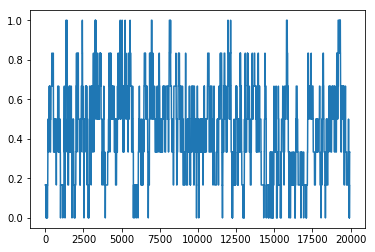

In [217]:
def show_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg
avg = show_dataset(train_dataset)
plt.plot(avg)
plt.show()

In [218]:
n_hidden = [128, 64]
n_embedding = n_nodes
keepprob = 0.9
lr = 1e-2
wd = 1e-3
optimizer = lambda p: torch.optim.Adam(p, lr=lr, weight_decay=wd)
loss = torch.nn.BCELoss(reduction='none')
scheduler = lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=0.2)
use_cuda = torch.cuda.is_available()

model = dl.basicMarkovCompleteVAE(graph, n_hidden, n_embedding,
                                  keepprob=keepprob, optimizer=optimizer, loss=loss, scheduler=scheduler,
                                  use_cuda=use_cuda)

In [219]:
model.fit(train_dataset,
          val_dataset=val_dataset,
          epochs=50,
          batch_size=128,
          verbose=True,
          keep_best=True,
          training_metrics=['loss', 'recon', 'kl_div'],
          model_metrics=['lr'],
          show_var=False,
          beta=1)

New best Epoch: 0 - Time: 0.00
	 Train. - loss: 2.9062, recon: 0.6957, kl_div: 2.2105, 
	 Val. - loss: 2.9014, recon: 0.6974, kl_div: 2.2040, 
New best Epoch: 1 - Time: 2.20, lr: 0.01
	 Train. - loss: 0.2947, recon: 0.1433, kl_div: 0.1514, 
	 Val. - loss: 0.3149, recon: 0.1471, kl_div: 0.1678, 
New best Epoch: 2 - Time: 1.37, lr: 0.01
	 Train. - loss: 0.2050, recon: 0.1214, kl_div: 0.0836, 
	 Val. - loss: 0.2134, recon: 0.1311, kl_div: 0.0823, 
Epoch: 3 - Time: 1.40, lr: 0.01
New best Epoch: 4 - Time: 1.39, lr: 0.01
	 Train. - loss: 0.1965, recon: 0.1066, kl_div: 0.0898, 
	 Val. - loss: 0.1829, recon: 0.1065, kl_div: 0.0764, 
New best Epoch: 5 - Time: 1.67, lr: 0.01
	 Train. - loss: 0.1696, recon: 0.1045, kl_div: 0.0651, 
	 Val. - loss: 0.1798, recon: 0.1071, kl_div: 0.0727, 
Epoch: 6 - Time: 2.60, lr: 0.01
New best Epoch: 7 - Time: 2.58, lr: 0.01
	 Train. - loss: 0.1023, recon: 0.0982, kl_div: 0.0041, 
	 Val. - loss: 0.1105, recon: 0.1071, kl_div: 0.0033, 
New best Epoch: 8 - Time: 1.

In [220]:
model.save_state(f_prefix)

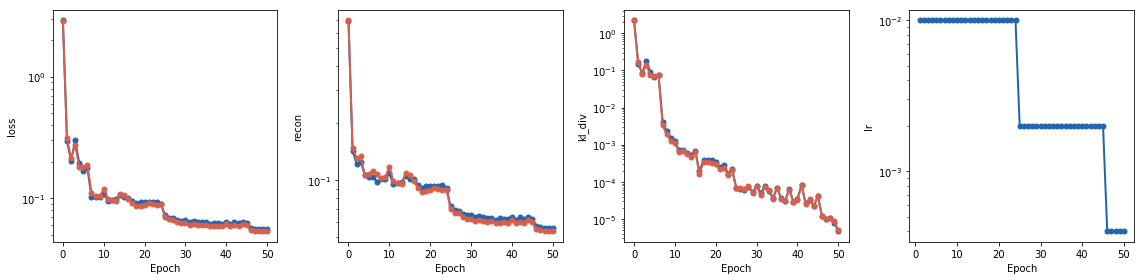

In [221]:
fig, ax = plt.subplots(1, 4,figsize=(16, 4))
_ax = {}
metrics = ['loss', 'recon', 'kl_div', 'lr']
for i, m in enumerate(metrics):
#     ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    _ax[m] = ax[i]

model.history.plot(training_metrics = ['loss', 'recon', 'kl_div'], model_metrics=['lr'],ax=(fig,_ax))
plt.tight_layout()

fig.savefig(os.path.join(f_prefix, 'training.png'))
plt.show()

In [138]:
def reconstruct_TS(graph, model, dataset, time_step, dt):
    transform = [dl.SIS_StateToFloat()]
    t = 0
    past = dataset[0][0].numpy()
    real_ts = []
    learned_ts = []
    while(t < time_step):
        t += 1
        real_prob = dataset.get_transition_probability(graph, past, dt)
        past = torch.tensor(past).float()
        learned_prob, _, _ = model.predict(past, batch_size=128)
        learned_prob = np.mean(learned_prob, 0)
        learned_present = torch.bernoulli(torch.tensor(learned_prob)).numpy()
        real_present = torch.bernoulli(torch.tensor(learned_prob)).numpy()
        learned_ts.append(learned_present)
        real_ts.append(real_present)
        past = real_present
    
    return np.array(real_ts), np.array(learned_ts)
        
        
        


In [67]:
real, learned = reconstruct_TS(graph, model, train_dataset, 2000, dt)
print(real.shape, learned.shape)
real_TS, learned_TS = np.mean(real, 1), np.mean(learned, 1)
print(real_TS.shape, learned_TS.shape)

(2000, 4) (2000, 4)
(2000,) (2000,)


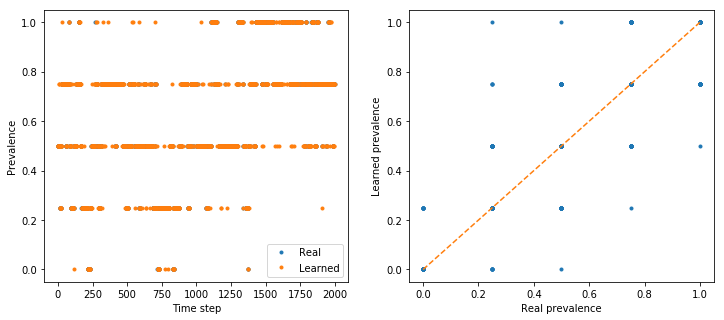

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(real_TS, '.', label='Real')
ax[0].plot(learned_TS, '.', label='Learned')
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Prevalence')
ax[0].legend()

ax[1].plot(real_TS, learned_TS, '.')
ax[1].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')
ax[1].set_xlabel('Real prevalence')
ax[1].set_ylabel('Learned prevalence')
plt.show()

In [222]:
def get_transitionProb(graph, model, dataset, epsilon=None):
    all_states = train_dataset.enumerate_all_states(graph)
    
    realTransProb = np.zeros([len(all_states), len(all_states)])
    learnedTransProb = np.zeros([len(all_states), len(all_states)])
    
    for j, past in enumerate(all_states):
        _past = torch.tensor(past).float()

        realProb = train_dataset.get_transition_probability(graph, past, dt)
        learnedProb, _, _ = model.predict(_past, batch_size=64)
        learnedProb = np.mean(learnedProb, 0)
        
        for i, present in enumerate(all_states):
            present_real_prob = present * realProb + (1 - present) * (1 - realProb)
            present_learned_prob = present * learnedProb + (1 - present) * (1 - learnedProb)
            realTransProb[i, j] = np.prod(present_real_prob)
            learnedTransProb[i, j] = np.prod(present_learned_prob)
    
    if epsilon:
        realTransProb[realTransProb == 0] = epsilon
        learnedTransProb[learnedTransProb == 0] = epsilon
    
    realTransProb /= np.sum(realTransProb, 0)
    learnedTransProb /= np.sum(learnedTransProb, 0)
    
    return realTransProb, learnedTransProb


def bit_to_value(array):
    d = array.shape
    bit = 2**np.arange(d)
    return np.sum(array * bit)

def bit_to_value_torch(array):
    d = array.size(0)
    bit = 2**torch.arange(d).float()
    return int(torch.sum(array * bit))
    

def get_transitionOccurence(graph, dataset, epsilon=None):
    all_states = train_dataset.enumerate_all_states(graph)
    n = graph.number_of_nodes()
    occurence = np.zeros([2**n, 2**n])
    data = dataset.complete_data
    
    for d in data:
        present, past = d
        i, j = bit_to_value_torch(present), bit_to_value_torch(past)
        
        occurence[i, j] += 1
    
    if epsilon:
        occurence[occurence == 0] = epsilon
    
    return occurence / np.sum(occurence)
    
    
    
    

In [223]:
realTransProb, learnedTransProb = get_transitionProb(graph, model, train_dataset, epsilon=1e-50)
occurence = get_transitionOccurence(graph, train_dataset, epsilon=1e-50)

np.savetxt(os.path.join(f_prefix, "real_transition_prob.txt"), realTransProb)
np.savetxt(os.path.join(f_prefix, "learned_transition_prob.txt"), learnedTransProb)
np.savetxt(os.path.join(f_prefix, "config_occurence.txt"), occurence)

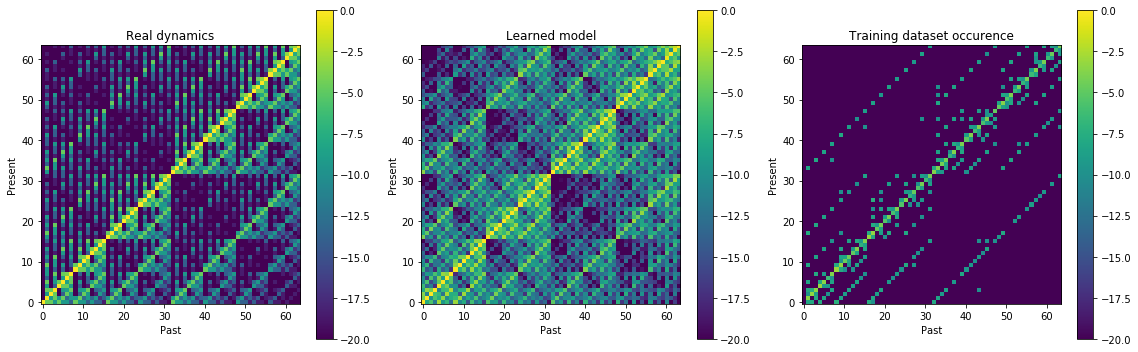

In [224]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

cs = ax[0].imshow(np.log(realTransProb), origin='lower', vmin=-20, vmax=0)
# ax[0].xaxis.tick_top()
ax[0].set_xlabel('Past')
ax[0].set_ylabel('Present')
ax[0].set_title('Real dynamics')
plt.colorbar(cs, ax=ax[0])

ax[1].imshow(np.log(learnedTransProb), origin='lower', vmin=-20, vmax=0)
# ax[1].xaxis.tick_top()
ax[1].set_xlabel('Past')
ax[1].set_ylabel('Present')
ax[1].set_title('Learned model')
plt.colorbar(cs, ax=ax[1])

cs = ax[2].imshow(np.log(occurence), origin='lower', vmin=-20, vmax=0)
ax[2].set_xlabel('Past')
ax[2].set_ylabel('Present')
ax[2].set_title('Training dataset occurence')
plt.colorbar(cs, ax=ax[2])
plt.tight_layout()

fig.savefig(os.path.join(f_prefix, "transition_prob.png"))

plt.show()